# Milestone III

### Wczytanie danych z poprzedniego milestone'a

In [6]:
### Wczytanie danych z poprzedniego milestone'a
import pandas as pd
import zipfile
import os

# --- Unzip and load datasets ---
# Unzip the dataset
with zipfile.ZipFile('dataset_step_2.zip', 'r') as zipf:
    zipf.extractall('extracted_datasets')

# Load the datasets
X_encoded_train = pd.read_csv('extracted_datasets/X_encoded_train_step_2.csv')  
X_encoded_valid = pd.read_csv('extracted_datasets/X_encoded_valid_step_2.csv')
y_train = pd.read_csv('extracted_datasets/y_train_step_2.csv')
y_valid = pd.read_csv('extracted_datasets/y_valid_step_2.csv')

# --- Convert y to Series, if needed ---
y_train = y_train.iloc[:, 0]  # Zakładam, że jest jedna kolumna z etykietami
y_valid = y_valid.iloc[:, 0]

# --- Optional cleanup: remove extracted files and directory ---
for file in os.listdir('extracted_datasets'):
    os.remove(os.path.join('extracted_datasets', file))
os.rmdir('extracted_datasets')

print("Zbiory wczytane: X_encoded_train, X_encoded_valid, y_train, y_valid")
print(f"Rozmiary: Train: {X_encoded_train.shape}, Valid: {X_encoded_valid.shape}")

Zbiory wczytane: X_encoded_train, X_encoded_valid, y_train, y_valid
Rozmiary: Train: (721746, 18), Valid: (309320, 18)


In [7]:
with zipfile.ZipFile('dataset_step_1.zip', 'r') as zipf:
    zipf.extractall('extracted_datasets')

X_encoded_test = pd.read_csv('extracted_datasets/X_encoded_test.csv')
y_test = pd.read_csv('extracted_datasets/y_test.csv')
print("Zbiory wczytane: X_encoded_test, y_test")
print(f"Rozmiary: Train: {X_encoded_test.shape}")

Zbiory wczytane: X_encoded_test, y_test
Rozmiary: Train: (441886, 24)


### Definicja potrzebnych funkcji

In [8]:
import numpy as np

def calculate_coefficients(median_fraud_amount, median_legit_amount):
    """
    Calculate FN, FP, TP, TN coefficients based on median fraud and legit transaction amounts.

    FN_COEFF  # Loss for missing a fraud (negative: fraud cost)
    FP_COEFF  # Loss for flagging legit transaction (negative: lost revenue + costs)
    TP_COEFF  # Savings for catching a fraud (positive: avoided fraud cost)
    TN_COEFF  # Savings for processing legit transaction (positive: revenue)

    Parameters:
    - median_fraud_amount: Median transaction amount for fraudulent transactions
    - median_legit_amount: Median transaction amount for legitimate transactions
    
    Returns:
    - FN_COEFF, FP_COEFF, TP_COEFF, TN_COEFF: Estimated coefficients
    """
    # Assumed costs (industry standards)
    chargeback_fee = 25        # Chargeback fee for fraud (FN)
    investigation_cost_fn = 5   # Investigation cost for missed fraud (FN)
    investigation_cost_fp_tp = 10  # Investigation cost for flagged transactions (FP, TP)
    churn_fraud = 50           # Churn cost for fraud (5% of $1,000 CLV)
    churn_legit = 20           # Churn cost for legit (2% of $1,000 CLV)
    
    # Coefficients
    FN_COEFF = -(median_fraud_amount + chargeback_fee + investigation_cost_fn + churn_fraud)
    FP_COEFF = -(median_legit_amount + investigation_cost_fp_tp + churn_legit)
    TP_COEFF = median_fraud_amount - investigation_cost_fp_tp
    TN_COEFF = median_legit_amount
    
    return FN_COEFF, FP_COEFF, TP_COEFF, TN_COEFF


def calculate_real_savings(y_true, y_pred, transaction_amounts):
    """
    Calculate Real Savings using actual transaction values.
    
    Parameters:
    - y_true: True labels (0=legit, 1=fraud)
    - y_pred: Predicted labels (0=legit, 1=fraud)
    - transaction_amounts: Actual transaction amounts (array-like)
    
    Returns:
    - real_savings: (x_real - n_real) / (N_real - n_real), clamped to 0-1
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    transaction_amounts = np.array(transaction_amounts)
    
    # Assumed costs
    chargeback_fee = 25
    investigation_cost_fn = 5
    investigation_cost_fp_tp = 10
    churn_fraud = 50
    churn_legit = 20
    
    # Masks for TP, FP, FN, TN
    tp_mask = (y_true == 1) & (y_pred == 1)
    fp_mask = (y_true == 0) & (y_pred == 1)
    fn_mask = (y_true == 1) & (y_pred == 0)
    tn_mask = (y_true == 0) & (y_pred == 0)
    
    # Real costs/savings
    x_real = (np.sum(transaction_amounts[tp_mask] - investigation_cost_fp_tp) +  # TP
              np.sum(transaction_amounts[tn_mask]) -  # TN
              np.sum(transaction_amounts[fn_mask] + chargeback_fee + investigation_cost_fn + churn_fraud) -  # FN
              np.sum(transaction_amounts[fp_mask] + investigation_cost_fp_tp + churn_legit))  # FP
    N_real = (np.sum(transaction_amounts[y_true == 1] - investigation_cost_fp_tp) +  # Best-case
              np.sum(transaction_amounts[y_true == 0]))
    n_real = (np.sum(transaction_amounts[y_true == 0]) -  # Worst-case
              np.sum(transaction_amounts[y_true == 1] + chargeback_fee + investigation_cost_fn + churn_fraud))
    
    if N_real - n_real == 0:
        return 0.0
    real_savings = (x_real - n_real) / (N_real - n_real)
    return max(0, min(1, real_savings))

# Calculate median transaction amounts for fraud and legit
median_fraud_amount = X_encoded_train['Transaction_Amount'][y_train == 1].median() if np.sum(y_train == 1) > 0 else 1
median_legit_amount = X_encoded_train['Transaction_Amount'][y_train == 0].median() if np.sum(y_train == 0) > 0 else 1

# Define coefficients
FN_COEFF, FP_COEFF, TP_COEFF, TN_COEFF = calculate_coefficients(median_fraud_amount=median_fraud_amount, median_legit_amount=median_legit_amount)

def calculate_estimated_savings(y_true, y_pred):
    """
    Calculate Estimated Savings using fixed coefficients.
    
    Parameters:
    - y_true: True labels (0=legit, 1=fraud)
    - y_pred: Predicted labels (0=legit, 1=fraud)
    
    Returns:
    - est_savings: (x - n) / (N - n), clamped to 0-1
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate TP, FP, FN, TN
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    
    # Estimated net savings
    x = tp * TP_COEFF + tn * TN_COEFF + fn * FN_COEFF + fp * FP_COEFF
    total_frauds = np.sum(y_true == 1)
    total_legit = np.sum(y_true == 0)
    N = total_frauds * TP_COEFF + total_legit * TN_COEFF
    n = total_legit * TN_COEFF + total_frauds * FN_COEFF
    
    if N - n == 0:
        return 0.0
    est_savings = (x - n) / (N - n)
    return max(0, min(1, est_savings))  # Clamp to 0-1

print(f"median fraud amount: {median_fraud_amount}\nmedian savings amount: {median_legit_amount}\nFN_COEFF: {FN_COEFF},\nFP_COEFF: {FP_COEFF},\nTP_COEFF: {TP_COEFF},\nTN_COEFF: {TN_COEFF}")

median fraud amount: 254.32
median savings amount: 148.49
FN_COEFF: -334.32,
FP_COEFF: -178.49,
TP_COEFF: 244.32,
TN_COEFF: 148.49


In [9]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict

def compare_approaches_cv(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_valid: pd.DataFrame,
    y_valid: np.ndarray,
    approaches: list,
    cv_folds: int = 5,
    charts_per_row: int = 2,
    transaction_col: str = "Transaction_Amount",
    include_transaction: bool = False,      # ← new flag
):
    # -- 1) Validate inputs
    if not isinstance(X_train, pd.DataFrame) or not isinstance(X_valid, pd.DataFrame):
        raise ValueError("X_train and X_valid must be pandas DataFrames")
    if X_train.shape[0] != len(y_train) or X_valid.shape[0] != len(y_valid):
        raise ValueError("Number of rows in X must match length of y labels")
    if transaction_col not in X_train.columns or transaction_col not in X_valid.columns:
        raise KeyError(f"{transaction_col!r} column missing from X_train/X_valid")

    # -- 2) Prepare feature matrices
    if include_transaction:
        # keep all columns, including the transaction amount
        feature_cols = list(X_train.columns)
    else:
        # drop the transaction amount from features
        feature_cols = [c for c in X_train.columns if c != transaction_col]

    Xtr = X_train[feature_cols].values
    Xv  = X_valid[feature_cols].values

    # -- always extract the amounts for savings calculations
    amt_tr = X_train[transaction_col].values
    amt_v  = X_valid[transaction_col].values

    # -- 3) Setup plot grid
    n = len(approaches)
    n_cols = max(1, min(charts_per_row, n))
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten() if n > 1 else [axes]

    os.makedirs("saved_models", exist_ok=True)

    # -- 4) Stratified CV + evaluate
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    for idx, app in enumerate(approaches):
        clf_name  = app['clf_name']
        clf       = app['clf']
        save_name = app.get('save_name', f"{clf_name.replace(' ','_')}.joblib")
        save_path = os.path.join("saved_models", save_name)

        # 4a) Out-of-fold probabilities on TRAIN
        p_tr_cv = cross_val_predict(
            clf, Xtr, y_train,
            cv=skf, method='predict_proba'
        )[:, 1]
        y_tr_cv = (p_tr_cv >= 0.5).astype(int)

        # 4b) Fit on full TRAIN and save model
        clf.fit(Xtr, y_train)
        joblib.dump(clf, save_path)

        # 4c) Evaluate on HOLD-OUT
        p_val      = clf.predict_proba(Xv)[:, 1]
        y_val_pred = (p_val >= 0.5).astype(int)

        # 4d) Metrics
        def _conf(y_true, y_pred):
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tn = np.sum((y_true == 0) & (y_pred == 0))
            recall_0 = tn / (tn + fp)
            recall_1 = tp / (tp + fn)
            return tp, fp, fn, tn, recall_0, recall_1

        tp_tr, fp_tr, fn_tr, tn_tr, r0_tr, r1_tr = _conf(y_train, y_tr_cv)
        tp_v, fp_v, fn_v, tn_v, r0_v, r1_v       = _conf(y_valid, y_val_pred)
        auc_tr = roc_auc_score(y_train, p_tr_cv)
        auc_v  = roc_auc_score(y_valid, p_val)
        est_tr = calculate_estimated_savings(y_train, y_tr_cv)
        est_v  = calculate_estimated_savings(y_valid, y_val_pred)
        # Real savings always uses the transaction amounts
        real_tr = calculate_real_savings(y_train, y_tr_cv, amt_tr)
        real_v  = calculate_real_savings(y_valid, y_val_pred, amt_v)

        # 4e) Plot ROC curves
        fpr_tr, tpr_tr, _ = roc_curve(y_train, p_tr_cv)
        fpr_v, tpr_v, _   = roc_curve(y_valid, p_val)
        ax = axes[idx]
        ax.plot(fpr_tr, tpr_tr, label=f'Train CV (AUC={auc_tr:.2f})')
        ax.plot(fpr_v,  tpr_v,  label=f'Valid   (AUC={auc_v:.2f})')
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(clf_name + (" (with Transaction)" if include_transaction else ""))
        ax.legend(loc='upper left')

        # 4f) Metrics table
        metrics = [
            ('TP', tp_tr, tp_v), ('FP', fp_tr, fp_v),
            ('FN', fn_tr, fn_v), ('TN', tn_tr, tn_v),
            ('Recall 0', r0_tr, r0_v), ('Recall 1', r1_tr, r1_v),
            ('Est. Sav %', est_tr, est_v), ('Real Sav %', real_tr, real_v)
        ]
        cellText = [['Metric', 'Train', 'Test']] + [
            [name,
             f"{tr:.0f}" if name in ('TP','FP','FN','TN') else f"{tr:.2f}",
             f"{val:.0f}" if name in ('TP','FP','FN','TN') else f"{val:.2f}"]
            for name, tr, val in metrics
        ]
        tbl = ax.table(
            cellText=cellText,
            colWidths=[0.3, 0.2, 0.2],
            loc='lower right', bbox=[0.5, 0.05, 0.45, 0.4]
        )
        for (r, c), cell in tbl.get_celld().items():
            cell.set_linewidth(0.5)
            if r == 0:
                cell.set_text_props(fontweight='bold')

    # 5) Clean up empty axes and show plot
    for j in range(len(approaches), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


In [10]:
from sklearn.metrics import make_scorer
 
def estimated_savings_score(y_true, y_pred):
    return calculate_estimated_savings(y_true, y_pred)
 
custom_scorer = make_scorer(estimated_savings_score, greater_is_better=True)

In [11]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
 
def stack_from_saved(
    X_train, y_train,
    X_valid, y_valid,
    model_paths,                    # dict[str, str]: name → path to .joblib
    sampling_method_name=None,      # optional title prefix
    amount_column_name="Transaction_Amount",
    save_model_path=None           # Optional: path to save the meta-learner model
):
    """
    Load pre‐trained classifiers from disk, stack them with a LogisticRegression
    meta‐learner, and plot ROC + metrics.
 
    Parameters
    ----------
    X_train, y_train : DataFrame / Series
    X_valid, y_valid : DataFrame / Series
    model_paths : dict
        Keys are names (used in legend & column headers), values are paths to joblib files.
    sampling_method_name : str, optional
        A prefix for the plot title (e.g. the sampling-method you used).
    amount_column_name : str
        Column to drop before feeding into the base models.
    save_model_path : str, optional
        Path to save the trained meta-learner model to.
 
    Returns
    -------
    meta_learner : fitted LogisticRegression
    """
    # 1. Strip out the amount column
    if not isinstance(X_train, pd.DataFrame) or not isinstance(X_valid, pd.DataFrame):
        raise ValueError("X_train and X_valid must be pandas DataFrames")
    if amount_column_name not in X_train.columns:
        raise ValueError(f"Column '{amount_column_name}' not in X_train")
 
    X_tr = X_train.drop(columns=[amount_column_name]).values
    X_val = X_valid.drop(columns=[amount_column_name]).values
 
    # 2. Load each saved model and get its proba‐1 predictions
    train_preds = []
    valid_preds = []
    names = []
    for name, path in model_paths.items():
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Model file not found: {path}")
        clf = joblib.load(path)
        if not hasattr(clf, "predict_proba"):
            raise AttributeError(f"Loaded model '{name}' has no predict_proba")
        p_tr = clf.predict_proba(X_tr)[:, 1]
        p_val = clf.predict_proba(X_val)[:, 1]
        train_preds.append(p_tr)
        valid_preds.append(p_val)
        names.append(name)
 
    # 3. Stack‐matrix for meta learner
    X_meta_tr = np.vstack(train_preds).T   # shape (n_samples, n_models)
    X_meta_val = np.vstack(valid_preds).T
 
    # 4. Fit meta‐learner
    meta = LogisticRegression(max_iter = 10000, random_state=42)
    meta.fit(X_meta_tr, y_train)
 
    # 5. Meta predictions & metrics
    y_tr_hat  = meta.predict(X_meta_tr)
    y_val_hat = meta.predict(X_meta_val)
    p_tr_meta = meta.predict_proba(X_meta_tr)[:, 1]
    p_val_meta= meta.predict_proba(X_meta_val)[:, 1]
 
    def _conf(y, yhat):
        tp = np.sum((y==1)&(yhat==1))
        fp = np.sum((y==0)&(yhat==1))
        fn = np.sum((y==1)&(yhat==0))
        tn = np.sum((y==0)&(yhat==0))
        r0 = tn/(tn+fp) if (tn+fp)>0 else 0
        r1 = tp/(tp+fn) if (tp+fn)>0 else 0
        return tp, fp, fn, tn, r0, r1
 
    tp_tr, fp_tr, fn_tr, tn_tr, r0_tr, r1_tr = _conf(y_train,   y_tr_hat)
    tp_v,  fp_v,  fn_v,  tn_v,  r0_v,  r1_v  = _conf(y_valid,  y_val_hat)
 
    auc_tr = roc_auc_score(y_train,   p_tr_meta)
    auc_v  = roc_auc_score(y_valid,   p_val_meta)
    est_tr = calculate_estimated_savings(y_train,   y_tr_hat)
    est_v  = calculate_estimated_savings(y_valid,   y_val_hat)
    real_tr= calculate_real_savings(y_train,   y_tr_hat,   X_train[amount_column_name].values)
    real_v = calculate_real_savings(y_valid,   y_val_hat,   X_valid[amount_column_name].values)
 
    # 6. Plot
    fpr_tr, tpr_tr, _ = roc_curve(y_train, p_tr_meta)
    fpr_v,  tpr_v,  _ = roc_curve(y_valid, p_val_meta)
 
    title_prefix = f"{sampling_method_name} + " if sampling_method_name else ""
    plt.figure(figsize=(6,6))
    plt.plot(fpr_tr, tpr_tr, label=f"Train (AUC={auc_tr:.2f})")
    plt.plot(fpr_v,  tpr_v,  label=f"Test (AUC={auc_v:.2f})")
    plt.plot([0,1],[0,1],"k--", alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix}Stacked Model")
    plt.legend(loc="upper left")
 
    # 7. Metrics table
    rows = [
        ["Metric", "Train", "Test"],
        ["TP",  tp_tr,          tp_v],
        ["FP",  fp_tr,          fp_v],
        ["FN",  fn_tr,          fn_v],
        ["TN",  tn_tr,          tn_v],
        ["Recall 0", r0_tr,     r0_v],
        ["Recall 1", r1_tr,     r1_v],
        ["Est. Savings %", est_tr, est_v],
        ["Real Savings %", real_tr, real_v],
    ]
    # format
    for i in range(1, len(rows)):
        for j in [1,2]:
            fmt = "{:.0f}" if rows[i][0] in ["TP","FP","FN","TN"] else "{:.2f}"
            rows[i][j] = fmt.format(rows[i][j])
 
    table = plt.table(
        cellText=rows,
        colWidths=[0.35,0.25,0.25],
        loc="lower right",
        bbox=[0.38,0.03,0.60,0.40],
    )
    for (r,c), cell in table.get_celld().items():
        cell.set_linewidth(0.4)
        if r==0:
            cell.set_text_props(fontweight="bold")
 
    plt.tight_layout()
    plt.show()
 
    # 8. Optionally save the trained model
    if save_model_path:
        joblib.dump(meta, save_model_path)
 
    return meta  # Return the meta-learner model

In [ ]:
model_paths = {
    "LogReg":    "saved_models/logreg2.joblib",
    "RandomForest":    "saved_models/random_forest.joblib",
    "CatBoost":      "saved_models/catboost2.joblib",
}
 
meta_model = stack_from_saved(
    X_encoded_train, y_train,
    X_encoded_valid, y_valid,
    model_paths,
    save_model_path="saved_models/meta_model.joblib"
)

In [12]:
import os
import re
import warnings

import pandas as pd
import numpy as np
import kagglehub
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Suppress kagglehub warning
warnings.filterwarnings("ignore", message=".*outdated `kagglehub` version.*")

# 1) Download and load the datasets
download_path = kagglehub.dataset_download("kevinvagan/fraud-detection-dataset")
dataset_path = os.path.join(download_path, "Dataset")

df1 = pd.read_csv(os.path.join(dataset_path, "Dataset1.csv"))

# 2) Split df1 into train/validation sets
X = df1.drop(columns=["Is Fraudulent"])
y = df1["Is Fraudulent"]
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=777
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=777
)

# 3) Define custom transformers with get_feature_names_out
class UUIDSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, col, prefix):
        self.col = col; self.prefix = prefix; self.n_parts = None
    def fit(self, X, y=None):
        first = X[self.col].dropna().iloc[0]
        self.n_parts = len(first.split("-"))
        return self
    def transform(self, X):
        parts = X[self.col].str.split("-", expand=True)
        parts.columns = [f"{self.prefix}_part{i+1}" for i in range(parts.shape[1])]
        return parts
    def get_feature_names_out(self, input_features=None):
        return [f"{self.prefix}_part{i+1}" for i in range(self.n_parts)]

class DatetimeSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col; self.columns_ = ['trans_year','trans_month','trans_day','trans_hour']
    def fit(self, X, y=None): return self
    def transform(self, X):
        dt = pd.to_datetime(X[self.col], errors='coerce')
        return pd.DataFrame({
            'trans_year':  dt.dt.year,
            'trans_month': dt.dt.month,
            'trans_day':   dt.dt.day,
            'trans_hour':  dt.dt.hour,
        })
    def get_feature_names_out(self, input_features=None):
        return self.columns_

class AddressParser(BaseEstimator, TransformerMixin):
    def __init__(self, col, prefix):
        self.col = col; self.prefix = prefix
        self.regex = re.compile(
            r"^(?P<street>.+)\n"
            r"(?P<city>.+),\s*(?P<state>[A-Z]{2})\s*(?P<zip>\d{5})$"
        )
    def fit(self, X, y=None): return self
    def transform(self, X):
        out = {f"{self.prefix}_{fld}": [] for fld in ['street','city','state','zip']}
        for addr in X[self.col].fillna(''):
            m = self.regex.match(addr)
            for fld in ['street','city','state','zip']:
                out[f"{self.prefix}_{fld}"].append(m.group(fld) if m else np.nan)
        return pd.DataFrame(out)
    def get_feature_names_out(self, input_features=None):
        return [f"{self.prefix}_{fld}" for fld in ['street','city','state','zip']]

# 4) Build ColumnTransformer pipeline
preprocessor = ColumnTransformer([
    ('txn',  UUIDSplitter('Transaction ID','txn'),       ['Transaction ID']),
    ('cust', UUIDSplitter('Customer ID','cust'),         ['Customer ID']),
    ('dt',   DatetimeSplitter('Transaction Date'),       ['Transaction Date']),
    ('ship', AddressParser('Shipping Address','ship'),   ['Shipping Address']),
    ('bill', AddressParser('Billing Address','bill'),    ['Billing Address']),
], remainder='passthrough')

# 5) Wrap preprocessor into a DataFrame-transforming estimator
def make_dataframe_transformer(ct):
    class DataFramePreprocessor(BaseEstimator, TransformerMixin):
        def fit(self, X, y=None):
            ct.fit(X)
            self.columns_ = ct.get_feature_names_out()
            return self
        def transform(self, X):
            arr = ct.transform(X)
            return pd.DataFrame(arr, index=X.index, columns=self.columns_)
        def get_feature_names_out(self, input_features=None):
            return self.columns_
    return DataFramePreprocessor()

df_pre = make_dataframe_transformer(preprocessor)

# 6) Create a one-step Pipeline so fit_transform returns a DataFrame
pipeline_1 = Pipeline([
    ('pre', df_pre)
])

# 7) Fit/transform to get your named DataFrames
X_ensemble_train_1      = pipeline_1.fit_transform(X_train)
X_ensemble_test_1 = pipeline_1.transform(X_test)

cat_features = ['txn__txn_part1', 'txn__txn_part2', 'txn__txn_part3', 'txn__txn_part4',
       'txn__txn_part5', 'cust__cust_part1', 'cust__cust_part2',
       'cust__cust_part3', 'cust__cust_part4', 'cust__cust_part5',
       'dt__trans_year', 'dt__trans_month', 'dt__trans_day', 'dt__trans_hour',
       'ship__ship_street', 'ship__ship_city', 'ship__ship_state',
       'ship__ship_zip', 'bill__bill_street', 'bill__bill_city',
       'bill__bill_state', 'bill__bill_zip',
       'remainder__Payment Method', 'remainder__Product Category',
       'remainder__Customer Location', 'remainder__Device Used',
       'remainder__IP Address']

# Convert all categorical features to string dtype
for df in [X_ensemble_train_1, X_ensemble_test_1]:
    df[cat_features] = df[cat_features].astype(str)

num_cols = [
    'remainder__Transaction Amount',
    'remainder__Quantity',
    'remainder__Customer Age',
    'remainder__Account Age Days',
    'remainder__Transaction Hour',
]
for df in (X_ensemble_train_1, X_ensemble_test_1):
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')


# Build train→codes mapping and apply to both train & valid
for c in cat_features:
    # learn categories from TRAIN
    cats = X_ensemble_train_1[c].astype('category').cat.categories
    # map TRAIN → codes 0..N-1
    X_ensemble_train_1[c] = pd.Categorical(X_ensemble_train_1[c], categories=cats).codes
    # map VALID → same codes (unseen → -1)
    X_ensemble_test_1[c] = pd.Categorical(X_ensemble_test_1[c], categories=cats).codes

In [4]:
import os
import warnings
import pandas as pd
import numpy as np
import kagglehub

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Suppress that kagglehub warning
warnings.filterwarnings("ignore", message=".*outdated `kagglehub` version.*")

# 1) Download and load the dataset
download_path = kagglehub.dataset_download("kevinvagan/fraud-detection-dataset")
dataset_path  = os.path.join(download_path, "Dataset")
df1 = pd.read_csv(os.path.join(dataset_path, "Dataset1.csv"))

# 2) Split into train/validation sets
X = df1.drop(columns=["Is Fraudulent"])
y = df1["Is Fraudulent"]
X_temp, X_unused, y_temp, y_unused = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=777
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=777
)

# 3) Extract the “four gold” features
class SimpleFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dt = pd.to_datetime(X["Transaction Date"], errors="coerce")
        return pd.DataFrame({
            "dt__trans_hour":                dt.dt.hour,
            "remainder__Transaction Hour":   pd.to_numeric(X["Transaction Hour"],   errors="coerce"),
            "remainder__Transaction Amount": pd.to_numeric(X["Transaction Amount"], errors="coerce"),
            "remainder__Account Age Days":   pd.to_numeric(X["Account Age Days"],  errors="coerce"),
        }, index=X.index)

# 4) Enhanced transforms (each appends to the DataFrame)
class HourCyclicEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, hour_col="dt__trans_hour"):
        self.hour_col = hour_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        h   = X[self.hour_col].astype(float)
        rad = 2 * np.pi * h / 24
        extras = pd.DataFrame({
            f"{self.hour_col}_sin": np.sin(rad),
            f"{self.hour_col}_cos": np.cos(rad),
        }, index=X.index)
        return pd.concat([X, extras], axis=1)

log_amount = FunctionTransformer(
    lambda df: pd.concat([
        df,
        pd.DataFrame({"log_transaction_amount": np.log1p(df["remainder__Transaction Amount"])}, index=df.index)
    ], axis=1),
    validate=False
)

ratio_transform = FunctionTransformer(
    lambda df: pd.concat([
        df,
        pd.DataFrame({"amt_per_age": df["remainder__Transaction Amount"]/(df["remainder__Account Age Days"]+1)}, index=df.index)
    ], axis=1),
    validate=False
)

interaction_transform = FunctionTransformer(
    lambda df: pd.concat([
        df,
        pd.DataFrame({"hour_amt_inter": df["dt__trans_hour"]*df["remainder__Transaction Amount"]}, index=df.index)
    ], axis=1),
    validate=False
)

# 5) Build ensemble_3 pipeline
ensemble_3_pipeline = Pipeline([
    ("extract",     SimpleFeatureExtractor()),
    ("log_amt",     log_amount),
    ("hour_cyc",    HourCyclicEncoder("dt__trans_hour")),
    ("ratio",       ratio_transform),
    ("interaction", interaction_transform),
])

# 6) Fit & transform
X_ensemble_train_3      = ensemble_3_pipeline.fit_transform(X_train)
X_ensemble_validation_3 = ensemble_3_pipeline.transform(X_valid)

# 7) Prepare test dataset:
X_test = ensemble_3_pipeline.transform(X_unused)
y_test = y_unused

print("ensemble_3 train shape:",      X_ensemble_train_3.shape)
print("ensemble_3 valid shape:",      X_ensemble_validation_3.shape)
print("test shape:", X_test.shape)
print("Features:", X_ensemble_train_3.columns.tolist())

ensemble_3 train shape: (721746, 9)
ensemble_3 valid shape: (309320, 9)
test shape: (441886, 9)
Features: ['dt__trans_hour', 'remainder__Transaction Hour', 'remainder__Transaction Amount', 'remainder__Account Age Days', 'log_transaction_amount', 'dt__trans_hour_sin', 'dt__trans_hour_cos', 'amt_per_age', 'hour_amt_inter']


# Test modeli na danych testowych:

## Best LGBM

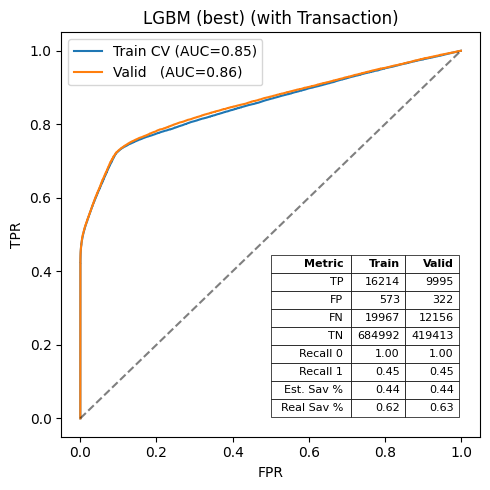

In [23]:
# %%  
import pandas as pd
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)

best_lgbm = LGBMClassifier(
                num_leaves=127,
                n_estimators=400,
                max_depth=5,
                learning_rate=0.1,
                random_state=42,
                verbose=-1
            )

compare_approaches_cv(
    X_ensemble_train_3, y_train,
    X_test, y_test,
    approaches=[
        {
            'clf_name': 'LGBM (best)',
            'clf': best_lgbm,
            'save_name': 'lgbm_best.joblib'
        },
    ],
    cv_folds=5,
    charts_per_row=1,
    include_transaction=True,
    transaction_col="remainder__Transaction Amount"
)


### Definicja pomocniczej funkcji do porównywania właściowości stackowania modelów

In [2]:
# %%  —— UPDATED stack_from_saved with optional saving ——
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score

def stack_from_saved(
    X_train, y_train,
    X_valid, y_valid,
    model_paths,                    # dict[str, str]  name → .joblib path
    sampling_method_name=None,      # optional title prefix
    amount_column_name="remainder__Transaction Amount",
    save_model_path=None            # NEW: where to dump the fitted meta model
):
    """
    Load pre-trained base models, build an XGB meta-learner stack, plot ROC,
    then (optionally) save the fitted meta model via joblib.
    """
    # --- 1. basic checks ----------------------------------------------------
    if not isinstance(X_train, pd.DataFrame) or not isinstance(X_valid, pd.DataFrame):
        raise ValueError("X_train and X_valid must be pandas DataFrames")
    if amount_column_name not in X_train.columns:
        raise ValueError(f"Column '{amount_column_name}' not in X_train")

    X_tr  = X_train.drop(columns=[]).values
    X_val = X_valid.drop(columns=[]).values

    # --- 2. collect base-model probabilities -------------------------------
    train_preds, valid_preds, names = [], [], []
    for name, path in model_paths.items():
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Model file not found: {path}")
        clf = joblib.load(path)
        if not hasattr(clf, "predict_proba"):
            raise AttributeError(f"Loaded model '{name}' has no predict_proba")
        train_preds.append(clf.predict_proba(X_tr)[:, 1])
        valid_preds.append(clf.predict_proba(X_val)[:, 1])
        names.append(name)

    X_meta_tr  = np.vstack(train_preds).T
    X_meta_val = np.vstack(valid_preds).T

    # --- 3. fit XGB meta learner -------------------------------------------
    meta = XGBClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.1,
        use_label_encoder=False, eval_metric="logloss", random_state=0
    )
    meta.fit(X_meta_tr, y_train)

    # --- 4. (optional) save -------------------------------------------------
    if save_model_path:
        joblib.dump(meta, save_model_path)

    # --- 5. evaluation & plot (unchanged) ----------------------------------
    y_tr_hat  = meta.predict(X_meta_tr)
    y_val_hat = meta.predict(X_meta_val)
    p_tr_meta = meta.predict_proba(X_meta_tr)[:, 1]
    p_val_meta= meta.predict_proba(X_meta_val)[:, 1]

    def _conf(y, yhat):
        tp = np.sum((y==1)&(yhat==1))
        fp = np.sum((y==0)&(yhat==1))
        fn = np.sum((y==1)&(yhat==0))
        tn = np.sum((y==0)&(yhat==0))
        r0 = tn/(tn+fp) if (tn+fp)>0 else 0
        r1 = tp/(tp+fn) if (tp+fn)>0 else 0
        return tp, fp, fn, tn, r0, r1

    tp_tr, fp_tr, fn_tr, tn_tr, r0_tr, r1_tr = _conf(y_train, y_tr_hat)
    tp_v,  fp_v,  fn_v,  tn_v,  r0_v,  r1_v  = _conf(y_valid, y_val_hat)

    auc_tr = roc_auc_score(y_train, p_tr_meta)
    auc_v  = roc_auc_score(y_valid, p_val_meta)
    est_tr = calculate_estimated_savings(y_train, y_tr_hat)
    est_v  = calculate_estimated_savings(y_valid, y_val_hat)
    real_tr= calculate_real_savings(y_train, y_tr_hat, X_train[amount_column_name].values)
    real_v = calculate_real_savings(y_valid, y_val_hat, X_valid[amount_column_name].values)

    # plotting …
    fpr_tr, tpr_tr, _ = roc_curve(y_train, p_tr_meta)
    fpr_v,  tpr_v,  _ = roc_curve(y_valid, p_val_meta)

    plt.figure(figsize=(6,6))
    title_prefix = f"{sampling_method_name} + " if sampling_method_name else ""
    plt.plot(fpr_tr, tpr_tr, label=f"Train (AUC={auc_tr:.2f})")
    plt.plot(fpr_v,  tpr_v,  label=f"Valid (AUC={auc_v:.2f})")
    plt.plot([0,1],[0,1],"k--", alpha=.6)
    plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix}Stacked Model"), plt.legend(loc="upper left")

    rows = [
        ["Metric","Train","Valid"],
        ["TP",tp_tr,tp_v],["FP",fp_tr,fp_v],["FN",fn_tr,fn_v],["TN",tn_tr,tn_v],
        ["Recall 0",r0_tr,r0_v],["Recall 1",r1_tr,r1_v],
        ["Est. Savings %",est_tr,est_v],["Real Savings %",real_tr,real_v],
    ]
    for i in range(1,len(rows)):
        for j in (1,2):
            rows[i][j] = f"{rows[i][j]:.0f}" if i<=4 else f"{rows[i][j]:.2f}"
    tbl = plt.table(rows, colWidths=[.35,.25,.25], loc="lower right", bbox=[.38,.03,.6,.4])
    for (r,c), cell in tbl.get_celld().items():
        cell.set_linewidth(.4)
        if r==0: cell.set_text_props(fontweight="bold")

    plt.tight_layout(); plt.show()
    return meta



## XGB

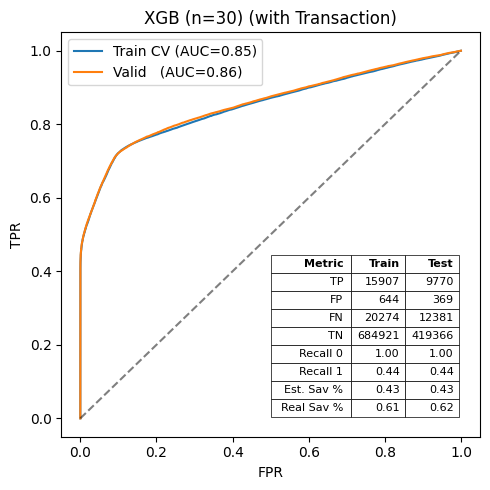

In [30]:
import pandas as pd
from xgboost import XGBClassifier


compare_approaches_cv(
    X_ensemble_train_3, y_train,
    X_test, y_test,
    approaches=[
            
    
            {
            'clf_name': 'XGB (n=30)',
            'clf': XGBClassifier(
                n_estimators=30,
                eval_metric='logloss',
                random_state=42
            ),
            'save_name': 'xgb_n=30.joblib'
        },
    ],
    cv_folds=5,
    charts_per_row=3,
    transaction_col="remainder__Transaction Amount",
    include_transaction=True,
)

## Stacking model

In [ ]:
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

 
 

meta_model = stack_from_saved(
    X_ensemble_train_3, y_train,
    X_test, y_test,
    {
    "linear": 'saved_models/logreg3.joblib',
    "lgbm": 'saved_models/lgbm_best.joblib',
    "xgb": 'saved_models/xgb_n=30.joblib'
},
    sampling_method_name="LGBM + XGB + LinearRegression",
    save_model_path="saved_models/stack_meta.joblib"
)

In [ ]:
# %%  — Real Savings for the saved stacked meta-model on TRAIN —  
import joblib, numpy as np, pandas as pd

X_input = X_test
y_input = y_test

# 1) Paths to the same base models you used when training the stack
model_paths = {
    "lgbm": 'saved_models/lgbm_best.joblib',
    "xgb": 'saved_models/xgb_n=30.joblib'
}

# 2) Re-create the meta-features for TRAIN  
train_preds = []
for name, path in model_paths.items():
    clf = joblib.load(path)
    train_preds.append(clf.predict_proba(X_input)[:, 1])

X_meta_tr = np.vstack(train_preds).T  # shape (n_samples, n_models)

# 3) Load the saved stacked meta-learner
meta = joblib.load("saved_models/stack_meta.joblib")

# 4) Class predictions from the meta-model
y_input_hat = meta.predict(X_meta_tr)

# 5) Compute Real Savings on the TRAIN set
real_sav_train = calculate_real_savings(
    y_input,
    y_input_hat,
    X_input["remainder__Transaction Amount"].values
)

print(f"Real Savings (stacked model) on TEST: {real_sav_train:.3f}")


/Users/adamryski/4sem/kochaML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Real Savings (stacked model) on TEST: 0.619
